In [77]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from torchvision.io import read_image
import warnings

# Deep Neural Networks Laboratory

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Preparation

This time, instead of using Custom Datasets, we will download the dataset directly from Torch.

In [79]:
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

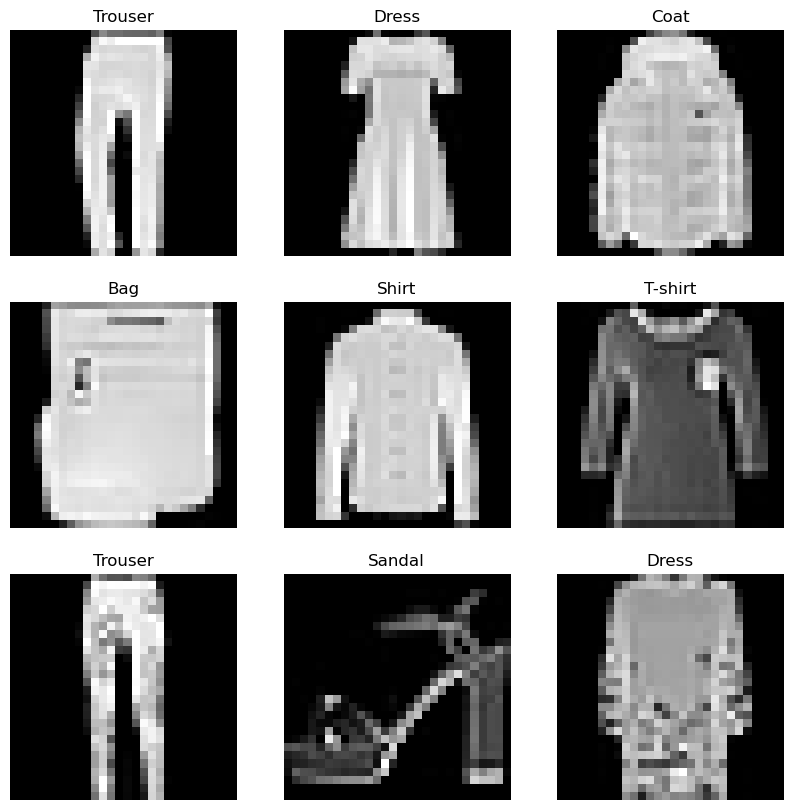

In [80]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [81]:
batch_size = 128

train_dataloader= DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Images in the Fashion MNIST dataset are 28x28 single channel images:

In [82]:
image, _ = train_data[sample_idx]
image.shape

torch.Size([1, 28, 28])

If they were colored, they would probably be RGB-coded, which implies they would have had 3 channels instead of 1, making them 3x28x28 tensors.

## Building a Residual Neural Network

We first build a BasicBlock for our residual.

You must keep in mind that the output shape from the Residual Block must be the same as the input, since we are going to sum them up.

![images/ResBlock.png](images/ResBlock.png) 

In [83]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)  

        # This convolution adjusts dimensions if necessary
        self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0) if in_channels != out_channels or stride != 1 else None

        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.conv_skip:
            identity = self.conv_skip(x)
        
        out2 = out + identity
        out = self.relu(out2)
        
        return out

Now we define our network as 2 basicblocks and then 3 classification layers.

We pass padding = 'same' to ensure that the output shape is the same as the input shape.

In [84]:
class ResNet(nn.Module):
    def __init__(self, num_classes=len(labels_map)):
        super(ResNet, self).__init__()
        self.conv1 = BasicBlock(1, 3, kernel_size=4, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = BasicBlock(3, 5, kernel_size=3, stride=1, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(245, 200)  
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ResNet()

In [85]:
net.to(device)

ResNet(
  (conv1): BasicBlock(
    (conv1): Conv2d(1, 3, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv_skip): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BasicBlock(
    (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv_skip): Conv2d(3, 5, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=245, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

In [86]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 1000 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # torch save model with torch.save()
  torch.save({'model_weights': model.state_dict()}, 'model.pt')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return (100*correct)

In [87]:
learning_rate = 1e-4
epochs = 30

In [88]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

accuracies = []
losses = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, net, loss_fn, optimizer)
  accuracies.append(test_loop(test_dataloader, net, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 2.325520  [  128/60000]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.606958 

Epoch 2
-------------------------------
loss: 0.487194  [  128/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.486604 

Epoch 3
-------------------------------
loss: 0.342195  [  128/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.438850 

Epoch 4
-------------------------------
loss: 0.288804  [  128/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.412997 

Epoch 5
-------------------------------
loss: 0.257793  [  128/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.396494 

Epoch 6
-------------------------------
loss: 0.239437  [  128/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.384775 

Epoch 7
-------------------------------
loss: 0.226828  [  128/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.375763 

Epoch 8
-------------------------------
loss: 0.216992  [  128/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.368368 

Epoch 9
----------------

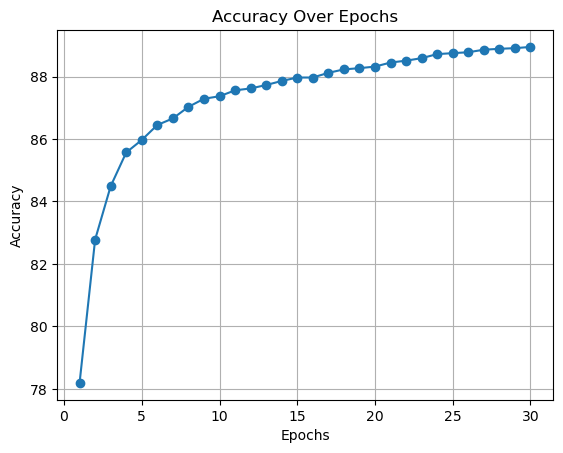

In [89]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

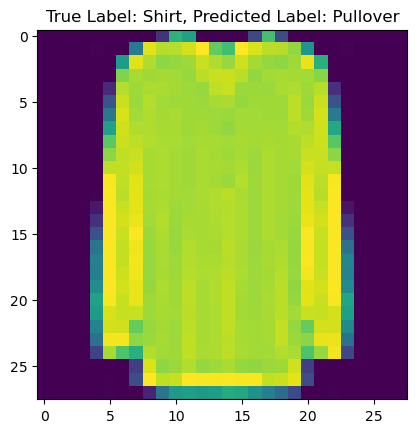

In [90]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

net.eval()

sample_index = random.randint(0, len(test_data) - 1)  
sample_image, true_label = test_data[sample_index]

sample_image = sample_image.unsqueeze(0).to(device)

with torch.no_grad():
    model_output = net(sample_image)

predicted_label = torch.argmax(model_output, dim=1).item()

image = transforms.ToPILImage()(sample_image.squeeze(0))

# Display the image and prediction
plt.imshow(image)
plt.title(f'True Label: {labels_map[true_label]}, Predicted Label: {labels_map[predicted_label]}')
plt.show()